In [113]:
import os
import pydiffvg
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import warp
from skimage import transform as tf
import imageio 
import matplotlib.font_manager as font_manager
import sys 
import torch
import torch.nn as nn
from torchvision import models, transforms
import PIL
from skimage.transform import resize
import torch.nn.functional as F

p = os.path.abspath('..')
sys.path.insert(1, p)
import sketch_utils as utils
from U2Net_.model import U2NET
from scipy import ndimage
from torchvision.utils import make_grid

device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")

In [114]:
def get_target(target_, device, image_scale=224):
    target = Image.open(target_)
    if target.mode == "RGBA":
        # Create a white rgba background
        new_image = Image.new("RGBA", target.size, "WHITE")
        # Paste the image on the background.
        new_image.paste(target, (0, 0), target)
        target = new_image
    target = target.convert("RGB")

    masked_im, mask = get_mask_u2net(target, device)
    
    # if args.mask_object:
    #     target = masked_im
    # if args.fix_scale:
    #     target = utils.fix_image_scale(target)

    transforms_ = []
    transforms_.append(transforms.Resize(
        image_scale, interpolation=PIL.Image.BICUBIC))
    transforms_.append(transforms.CenterCrop(image_scale))
    transforms_.append(transforms.ToTensor())
    data_transforms = transforms.Compose(transforms_)

    target_ = data_transforms(target).unsqueeze(0).to(device)
    mask = Image.fromarray((mask*255).astype(np.uint8)).convert('RGB')
    mask = data_transforms(mask).unsqueeze(0).to(device)
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    return target_, mask
    
def get_mask_u2net(pil_im, device, use_gpu=True):
    w, h = pil_im.size[0], pil_im.size[1]
    im_size = min(w, h)
    data_transforms = transforms.Compose([
        transforms.Resize(min(320, im_size), interpolation=PIL.Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(
            0.26862954, 0.26130258, 0.27577711)),
    ])

    input_im_trans = data_transforms(pil_im).unsqueeze(0).to(device)

    model_dir = os.path.join("/home/vinker/dev/backgroundCLIPasso/CLIPasso/U2Net_/saved_models/u2net.pth")
    net = U2NET(3, 1)
    if torch.cuda.is_available() and use_gpu:
        net.load_state_dict(torch.load(model_dir))
        net.to(device)
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()
    with torch.no_grad():
        d1, d2, d3, d4, d5, d6, d7 = net(input_im_trans.detach())
    pred = d1[:, 0, :, :]
    pred = (pred - pred.min()) / (pred.max() - pred.min())
    predict = pred
    
    predict[predict < 0.5] = 0
    predict[predict >= 0.5] = 1

    # opposite mask (mask the object insteadof background)
    # predict_dilated_back = 1 - torch.tensor(ndimage.binary_dilation(predict[0].cpu().numpy(), structure=np.ones((11,11))).astype(np.int)).unsqueeze(0)
    
    mask = torch.cat([predict, predict, predict], axis=0).permute(1, 2, 0)
    mask = mask.cpu().numpy()
    mask = resize(mask, (h, w), anti_aliasing=False)
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    
    im = Image.fromarray((mask[:, :, 0]*255).astype(np.uint8)).convert('RGB')
    # im.save(f"{args.output_dir}/mask.png")
    im_np = np.array(pil_im)
    im_np = im_np / im_np.max()
    im_np = mask * im_np
    im_np[mask == 0] = 1
    im_final = (im_np / im_np.max() * 255).astype(np.uint8)
    im_final = Image.fromarray(im_final)
    
    return im_final, mask

In [126]:
def read_svg(path_svg, multiply=False):
    device = torch.device("cuda" if (
        torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
    canvas_width, canvas_height, shapes, shape_groups = pydiffvg.svg_to_scene(
        path_svg)
    if multiply:
        canvas_width *= 2
        canvas_height *= 2
        for path in shapes:
            path.points *= 2
            path.stroke_width *= 2
    _render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = _render(canvas_width,  # width
                  canvas_height,  # height
                  2,   # num_samples_x
                  2,   # num_samples_y
                  0,   # seed
                  None,
                  *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + \
        torch.ones(img.shape[0], img.shape[1], 3,
                   device=device) * (1 - img[:, :, 3:4])
    img = img[:, :, :3]
    return img

def read_svg2(path_svg, opacity=0.5, multiply=False, width=1.0):
    device = torch.device("cuda" if (
        torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
    canvas_width, canvas_height, shapes, shape_groups = pydiffvg.svg_to_scene(
        path_svg)
    for group in shape_groups:
        group.stroke_color = torch.tensor([0,0,0,opacity])
    for path in shapes:
        if path.stroke_width <= 1:
            path.stroke_width = torch.tensor(0.0)
        else:
            path.stroke_width = torch.tensor(width)
    if multiply:
        # canvas_width *= 2
        # canvas_height *= 2
        for path in shapes:
            path.points -= canvas_width
            path.points *= 1.2
            path.points += canvas_width
            # path.points *= 2
            # path.stroke_width *= 2
    _render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = _render(canvas_width,  # width
                  canvas_height,  # height
                  2,   # num_samples_x
                  2,   # num_samples_y
                  0,   # seed
                  None,
                  *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + \
        torch.ones(img.shape[0], img.shape[1], 3,
                   device=device) * (1 - img[:, :, 3:4])
    img = img[:, :, :3]
    return img


def get_svg_path(folder_name, top_folder):
    files = os.listdir(f"{top_folder}/{folder_name}")
    path_svg_ = [f for f in files if "svg" in f][0]
    path_svg = f"{top_folder}/{folder_name}/{path_svg_}"
    return path_svg

def read_svg1(path_svg, multiply=False):
    device = torch.device("cuda" if (
        torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
    canvas_width, canvas_height, shapes, shape_groups = pydiffvg.svg_to_scene(
        path_svg)
    for group in shape_groups[-20:]:
        group.stroke_color = torch.tensor([0,0,0,0])
    if multiply:
        canvas_width *= 2
        canvas_height *= 2
        for path in shapes:
            path.points *= 2
            path.stroke_width *= 2
    _render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = _render(canvas_width,  # width
                  canvas_height,  # height
                  2,   # num_samples_x
                  2,   # num_samples_y
                  0,   # seed
                  None,
                  *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + \
        torch.ones(img.shape[0], img.shape[1], 3,
                   device=device) * (1 - img[:, :, 3:4])
    img = img[:, :, :3]
    return img


def plot_layers_sketch(files, input_image_path, mul=[0.05, 0.1, 0.2, 0.5, 0.5], plot=True, top_folder=""):
    sketches = []
    
    if plot:
        im = Image.open(input_image_path).resize((224,224)).convert('RGB')
        plt.figure(figsize=(int(len(files) * 4),10))
        plt.subplot(1,len(files) + 1,1)
        plt.imshow(im)
        plt.axis("off")
        
    final_sketch = np.zeros(np.array((224,224,3)).shape)
    for i in range(len(files)):
        f_ = files[i]
        m = mul[i]
    
        path_svg = get_svg_path(f_, top_folder)
        # sketch = read_svg1(path_svg, multiply=False).cpu()
        sketch = read_svg2(path_svg, opacity=1,width=1.5,multiply=False).cpu()

        
        if plot:
            plt.subplot(1,len(files) + 1, i + 2)
            plt.imshow(sketch)
            plt.title(f_)
            plt.axis("off")
        sketches.append(sketch.numpy())
        # final_sketch += m * 
    return sketches

def draw_layers(layers, num_s, files, top_folder, mask=None, input_image_path=""):
    mul = [1  for i in range(len(layers))]
    # mul[len(mul) // 2] = 2
    sketches = plot_layers_sketch(files, input_image_path=input_image_path, mul=mul, top_folder=top_folder, plot=False)
    
    # plt.figure(figsize=(int(len(files) * 4),10))
    # for j,s in enumerate(sketches):
    #     plt.subplot(1,len(files) + 1, j + 2)
    #     plt.imshow(s)
    #     plt.axis("off")
    # plt.show()
    # plt.close()
    
    sketches_blend = []
    sketches_m = []
    # plt.figure(figsize=(int(len(files) * 4),10))
    for j,s in enumerate(sketches):
        final_sketch = 0.4 * s
        # final_sketch = np.zeros(s.shape)
        w = 0.6 / (len(sketches))
        # w = 1 / (len(sketches))

        for j1, s1 in enumerate(sketches):
            final_sketch += w * s1
        k = 0.7
        # final_sketch = (1 - k) * mask + (k) * final_sketch
        if mask is not None:
            final_sketch = 1 - final_sketch
            final_sketch[mask == 1] = final_sketch[mask == 1] * 0.3
            final_sketch = 1 - final_sketch
            
            s_ = 1 - s
            s_[mask == 1] = s_[mask == 1] * 0.0
            s_ = 1 - s_
            sketches_m.append(s_)
        sketches_blend.append(final_sketch)
    #     plt.subplot(1,len(files) + 1, j + 2)
    #     plt.imshow(final_sketch)
    #     plt.axis("off")
    # plt.show()
    # plt.close()
    if mask is not None:
        return sketches_m, sketches_blend
    # final_sketch = final_sketch / final_sketch.max()
    return sketches, sketches_blend


# plt.imshow(final_sketch_back)
# plt.axis("off")
# plt.show()

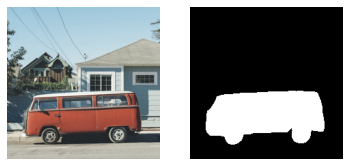

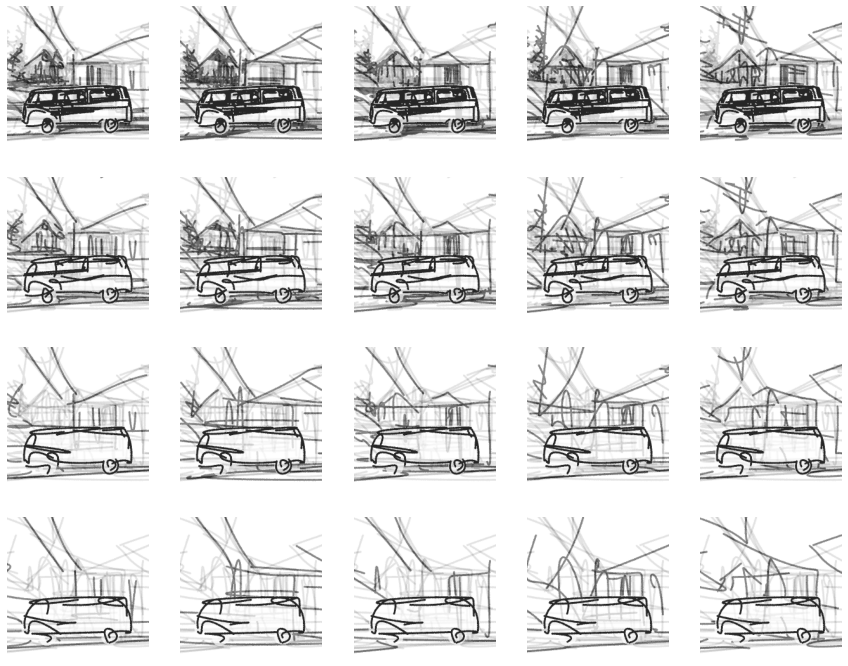

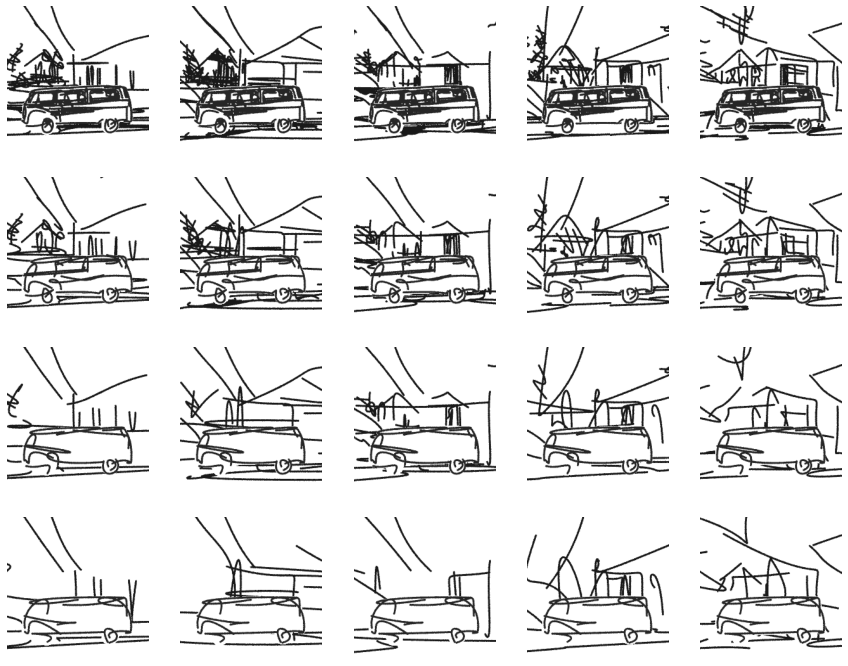

In [127]:
def plot_obj_on_back(sketches_simp, sketch_for_simp, output_name, draw_obj):
    plt.figure(figsize=(int(len(sketches_simp[0]) * 3), int(len(sketches_simp) * 3)))
    for i, w_s in enumerate(sketches_simp):
        sketches = w_s
        if draw_obj:
            sketch_for = sketch_for_simp[i]
        for j, s in enumerate(sketches):
            sketch_back = s
            final_ = sketch_back.copy()
            final_ = (1 - final_) * 0.9
            if draw_obj:
                sketch_for_op = (1 - sketch_for)
                final_[sketch_for_op > 0.0] = 0.85 * sketch_for_op[sketch_for_op > 0.0]
            final_ = 1 - final_
            plt.subplot(len(sketches_simp), len(sketches), i * len(sketches) + j + 1)
            # plt.subplot(i + 1, i * len(sketches) + len(sketches) + 1, j + 2)
            plt.imshow(final_)
            plt.axis("off")
    plt.savefig(f"matrixes/{output_name}.png")
    plt.show()  
    plt.close()
    

def plot_matrix(target_path, top_folder, layers, num_s, im_scale, res_folder_names_format, file_name, weights_back, weights_for, draw_obj=True, input_image_path=""):
    target, mask = get_target(target_path, device, image_scale=224)
    mask_np = mask[0].permute(1,2,0).cpu().numpy()
    
    plt.subplot(1,2,1)
    plt.imshow(target[0].permute(1,2,0).cpu())
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(mask_np)
    plt.axis("off")
    plt.savefig(f"matrixes/{file_name}_input.png")
    plt.show()
    plt.close()
    
    if not draw_obj:
        mask_np = None
    
    files = [res_folder_names_format["background_baseline"].format(layer=layer, num_s_back=num_s_back, file_name=file_name) for layer in layers]
    sketches, sketches_blend_back = draw_layers(layers, num_s_back, files, top_folder, mask=mask_np, input_image_path="")
    sketches_w = [sketches]
    sketches_blend_back_w = [sketches_blend_back]
    sketch_for_w = []
    
    if draw_obj:
        for_sketch_folder = res_folder_names_format["object_baseline"].format(num_s_obj_baseline=num_s_obj_baseline, file_name=file_name)
        for_sketch_path = get_svg_path(for_sketch_folder, top_folder)
        sketch_for = read_svg2(for_sketch_path, opacity=1, width=1.5).cpu().numpy()
        sketch_for_w = [sketch_for]
    
    for w_back, w_for in zip(weights_back, weights_for):
        files = [res_folder_names_format["background_simplify"].format(width_weight=w_back, num_s_back=num_s_back, file_name=file_name, layer=layer) for layer in layers]
        sketches, sketches_blend_back = draw_layers(layers, num_s_back, files, top_folder, mask=mask_np, input_image_path="")
        sketches_w.append(sketches)
        sketches_blend_back_w.append(sketches_blend_back)
        
        if draw_obj:
            for_sketch_folder = res_folder_names_format["object_simplify"].format(width_weight=w_for, num_s_obj_baseline=num_s_obj_baseline, file_name=file_name)
            for_sketch_path = path_svg = get_svg_path(for_sketch_folder, top_folder)
            sketch_for = read_svg2(for_sketch_path, opacity=1, width=1.5).cpu().numpy()
            sketch_for_w.append(sketch_for)
    
    output_name = f"{file_name}_blendback"
    plot_obj_on_back(sketches_blend_back_w, sketch_for_w, output_name, draw_obj=draw_obj)
    output_name = f"{file_name}_back"
    plot_obj_on_back(sketches_w, sketch_for_w, output_name, draw_obj=draw_obj)
    

# "woman_city", "london", "bull", "man_flowers"
# file_names = ["bull", "woman_city", "man_flowers"]
file_names = ["van"]
for file_name in file_names:
    # file_name = "bull"
    top_folder = "/home/vinker/dev/background_project/experiements/big_test_07_27/"
    target_ = f"/home/vinker/dev/input_images/background_sketching/{file_name}.jpg"
    im_scale = 224
    layers = [4, 6,7,8,11]
    num_s_back = 64
    num_s_obj_baseline = 64
    res_folder_names_format = {
        "object_baseline": "RN1_{num_s_obj_baseline}s_{file_name}",
        "background_baseline": "ViT_l{layer}_{num_s_back}s_{file_name}_mask",
        "object_simplify": "points1_width_L1_{width_weight}__switch5_clip_l4L2__{num_s_obj_baseline}s_{file_name}",
        "background_simplify": "points1_width_L1_{width_weight}__switch5_clip_l4L2__{num_s_back}s_{file_name}_l{layer}back"}

    weights_back = [0.0001, 0.0004, 0.001]
    weights_for = [0.0001, 0.0004, 0.001]

    plot_matrix(target_, top_folder, layers, num_s, im_scale, res_folder_names_format, file_name, weights_back, weights_for, draw_obj=True)




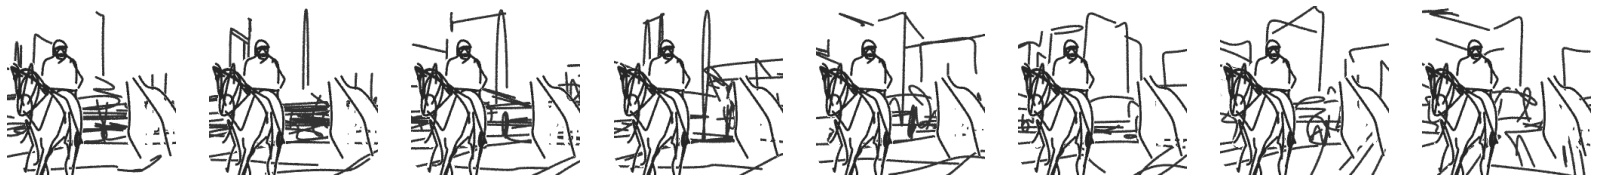

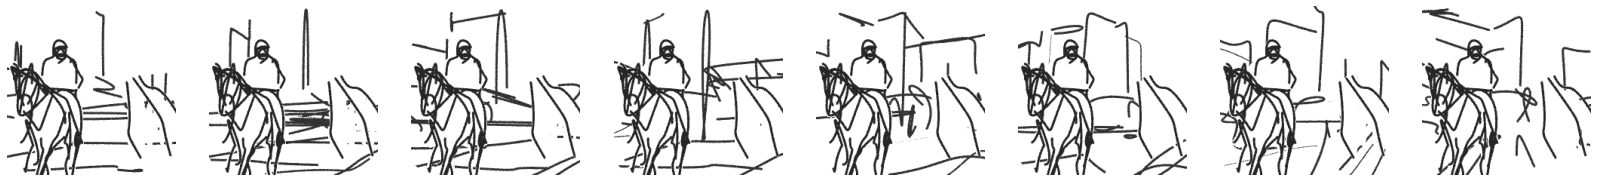

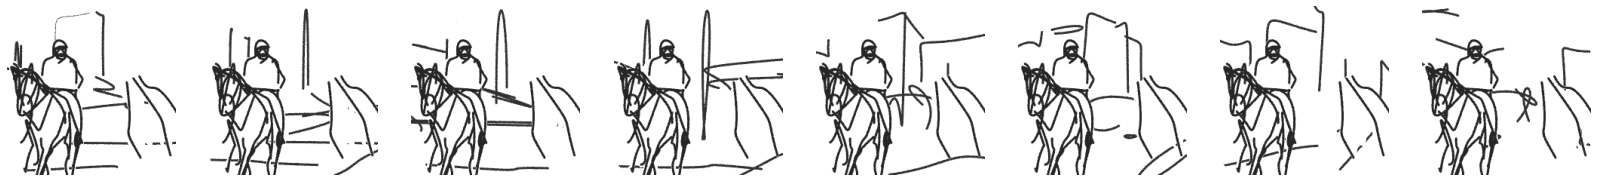

In [6]:


file_name = "complex-scene-crop_mask"
file_name = "semi-complex_mask"

input_image_path=f"/home/vinker/dev/background_project/notebooks/complex_level_scenes/{file_name}.png"
layers = range(3,11)
# layers = [3,4,7,9]
num_s = 32
top_folder = "/home/vinker/dev/background_project/experiements/width_05_07"
sketch_for2 = read_svg("/home/vinker/dev/background_project/experiements/05_29_image_divide/baseline_complex-scene-crop_32s/baseline_complex-scene-crop_32s_seed1000_best.svg").cpu().numpy()
# sketch_for2 = read_svg("/home/vinker/dev/background_project/experiements/05_29_image_divide/baseline_complex-scene-crop_16s/baseline_complex-scene-crop_16s_seed0_best.svg").cpu().numpy()
# sketch_for2 = read_svg("/home/vinker/dev/background_project/experiements/05_29_image_divide/baseline_semi-complex_32s/baseline_semi-complex_32s_seed1000_best.svg").cpu().numpy()
file_name="buildings"
# file_name="house"

#l10__width_L1_hinge16__l4Cos__32s_buildings_layer10
strokes = [30, 16, 8]
for st in strokes:
    # files = [f"l{j}__width_L1_hinge{st}__l4Cos__32s_buildings_layer{j}" for j in layers]
    files = [f"l{j}__width_L1_hinge{st}__l4Cos__32s_{file_name}_layer{j}" for j in layers]

    sketches, sketches_blend_back = draw_layers(input_image_path, file_name, layers, num_s, files, top_folder, mask=mask_np)
    
    plt.figure(figsize=(int(len(sketches_blend_back) * 4),10))
    for j, s in enumerate(sketches):
    # for j, s in enumerate(sketches_blend_back):
        sketch_back, sketch_for = s, s
        final_ = sketch_back.copy()
        final_ = (1 - final_) * 0.8
        sketch_for_op = (1 - sketch_for2)
        final_[sketch_for_op > 0.0] = 0.85 * sketch_for_op[sketch_for_op > 0.0]

        final_ = 1 - final_
        plt.subplot(1,len(sketches) + 1, j + 2)
        plt.imshow(final_)
        plt.axis("off")
    plt.show()  
    plt.close()

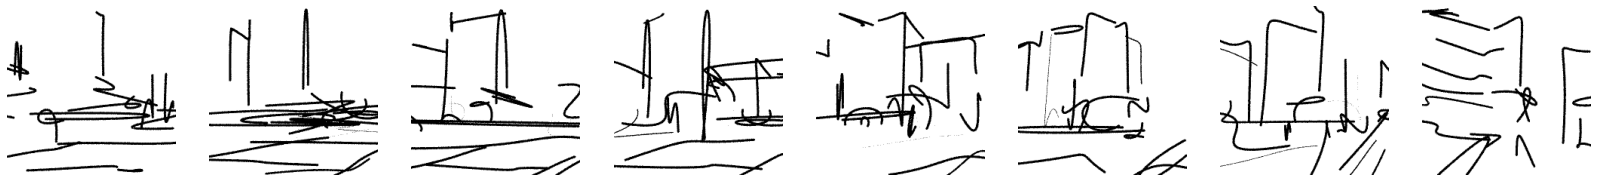

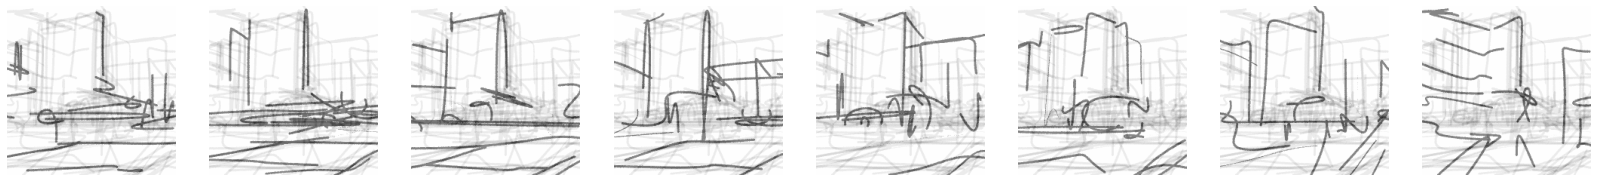

In [38]:
plt.figure(figsize=(int(len(sketches) * 4),10))
for j, s in enumerate(sketches):
    plt.subplot(1,len(sketches) + 1, j + 2)
    plt.imshow(s)
    plt.axis("off")
plt.show()
plt.close()

plt.figure(figsize=(int(len(sketches) * 4),10))
for j, s in enumerate(sketches_blend_back):
    plt.subplot(1,len(sketches) + 1, j + 2)
    plt.imshow(s)
    plt.axis("off")
plt.show()
plt.close()

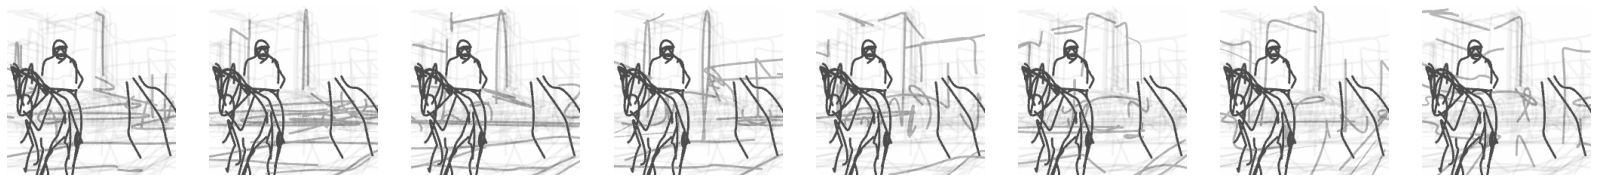

In [50]:
sketch_for2 = read_svg("/home/vinker/dev/background_project/experiements/05_29_image_divide/baseline_complex-scene-crop_32s/baseline_complex-scene-crop_32s_seed1000_best.svg").cpu().numpy()

plt.figure(figsize=(int(len(sketches_blend_back) * 4),10))
for j, s in enumerate(sketches_blend_back):
    sketch_back, sketch_for = s, s
    final_ = sketch_back.copy()
    final_ = (1 - final_) * 0.6
    sketch_for_op = (1 - sketch_for2)
    final_[sketch_for_op > 0.0] = 0.7 * sketch_for_op[sketch_for_op > 0.0]
    
    final_ = 1 - final_
    plt.subplot(1,len(sketches) + 1, j + 2)
    plt.imshow(final_)
    plt.axis("off")
plt.show()
plt.close()


# # final_[final_ < 0.9] = 0.8 * final_[final_ < 0.9]
# plt.imshow(final_)
# plt.axis("off")
# plt.show()


# plt.imshow(final_)
# plt.axis("off")
# plt.show()